In [2]:
import os, sys
from google.colab import drive
drive.mount('/content/mnt',force_remount=True)
nb_path = '/content/notebooks'
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path)
sys.path.insert(0, nb_path)  # or append(nb_path)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/mnt


In [3]:
!pip install git+https://github.com/arviz-devs/arviz

  Cloning https://github.com/arviz-devs/arviz to /tmp/pip-req-build-wa16v6c0
  Running command git clone -q https://github.com/arviz-devs/arviz /tmp/pip-req-build-wa16v6c0
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 4.3MB 4.5MB/s 
     |████████████████████████████████| 296kB 40.3MB/s 
  Created wheel for arviz: filename=arviz-0.9.0-cp36-none-any.whl size=2664768 sha256=f20ee6935b5725f0efb24e3f7fca2569240cd4fa0652fe091b1d20c34877d0e2
  Stored in directory: /tmp/pip-ephem-wheel-cache-huns0emn/wheels/93/b7/76/fe5931eb8154ca105ee91ddc249c6e1eaaa7b06988bdf8a400
Successfully built arviz


In [45]:
!pip install pymc4

# Linear basis function models with PyMC4

The following is a PyMC4 implementation of [Bayesian regression with linear basis function models](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression.ipynb). PyMC4 is still in an early state of development (an alpha release is available at the time of writing this notebook) i.e. the following code may break with future PyMC4 releases but I'll try to it keep up to date. A corresponding PyMC3 implementation is available [here](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression_pymc3.ipynb).

In [46]:
import logging
import pymc4 as pm
import numpy as np
import matplotlib.pyplot as plt
import arviz as az

from scipy.integrate import odeint,solve_ivp # to solve ODE system
import tensorflow as tf
import tensorflow_probability as tfp

print(pm.__version__)
print(tf.__version__)
print(tfp.__version__)
#print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

# Mute Tensorflow warnings ...
logging.getLogger('tensorflow').setLevel(logging.ERROR)

4.0a2
2.4.0-dev20200724
0.12.0-dev20200724


In [47]:
np.random.seed(20394)
#tf.device('/GPU:0')

In [48]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [49]:
# %tensorflow_version 2.x
# import tensorflow as tf
# import timeit

# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   print(
#       '\n\nThis error most likely means that this notebook is not '
#       'configured to use a GPU.  Change this in Notebook Settings via the '
#       'command palette (cmd/ctrl-shift-P) or the Edit menu.\n\n')
#   raise SystemError('GPU device not found')

# def cpu():
#   with tf.device('/cpu:0'):
#     random_image_cpu = tf.random.normal((100, 100, 100, 3))
#     net_cpu = tf.keras.layers.Conv2D(32, 7)(random_image_cpu)
#     return tf.math.reduce_sum(net_cpu)

# def gpu():
#   with tf.device('/device:GPU:0'):
#     random_image_gpu = tf.random.normal((100, 100, 100, 3))
#     net_gpu = tf.keras.layers.Conv2D(32, 7)(random_image_gpu)
#     return tf.math.reduce_sum(net_gpu)
  
# # We run each op once to warm up; see: https://stackoverflow.com/a/45067900
# cpu()
# gpu()

# # Run the op several times.
# print('Time (s) to convolve 32x7x7x3 filter over random 100x100x100x3 images '
#       '(batch x height x width x channel). Sum of ten runs.')
# print('CPU (s):')
# cpu_time = timeit.timeit('cpu()', number=10, setup="from __main__ import cpu")
# print(cpu_time)
# print('GPU (s):')
# gpu_time = timeit.timeit('gpu()', number=10, setup="from __main__ import gpu")
# print(gpu_time)
# print('GPU speedup over CPU: {}x'.format(int(cpu_time/gpu_time)))


## Introduction to PyMC4

PyMC4 uses [Tensorflow Probability](https://www.tensorflow.org/probability) (TFP) as backend and PyMC4 random variables are wrappers around TFP distributions. Models must be defined as [generator](https://docs.python.org/3/glossary.html#term-generator) functions, using a `yield` keyword for each random variable. PyMC4 uses [coroutines](https://www.python.org/dev/peps/pep-0342/) to interact with the generator to get access to random variables. Depending on the context, it may sample values from random variables, compute log probabilities of observed values, ... and so on. Details are covered in the [PyMC4 design guide](https://github.com/pymc-devs/pymc4/blob/master/notebooks/pymc4_design_guide.ipynb). Model generator functions must be decorated with ` @pm.model` as shown in the following trivial example:

In [50]:
@pm.model
def model(y):
    x = yield pm.Normal('x', loc=0, scale=10)
    y = yield pm.Normal('y', loc=x, scale=1, observed=y)
#    ode_system = yield pm.Deterministic()

`pm.sample()` samples from the posterior using NUTS. Samplers other than NUTS or variational inference methods are not implemented yet.

In [51]:
y = np.random.randn(30) + 3
print(y.dtype)
#isinstance(y, float)

float64


In [52]:
y = np.random.randn(30) + 3

trace = pm.sample(model(y), num_chains=3)
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

The returned `trace` object is an ArviZ [`InferenceData`](https://arviz-devs.github.io/arviz/notebooks/XarrayforArviZ.html) object. It contains posterior samples, observed data and sampler statistics. The posterior distribution over `x` can be displayed with:

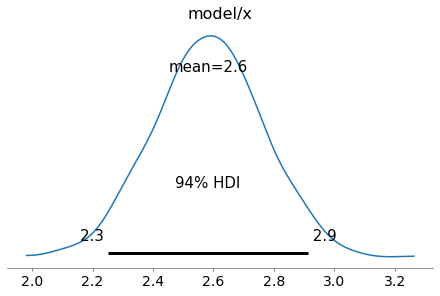

In [53]:
az.plot_posterior(trace, var_names=['model/x']);

Models can also be nested i.e. used like other PyMC4 random variables.

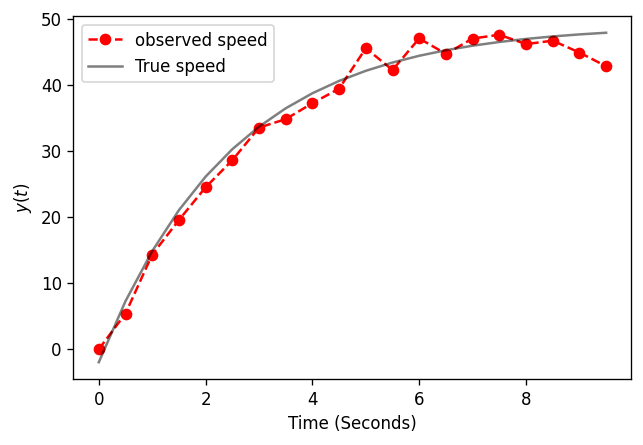

In [54]:
def freefall_Data(y, t, p):
    return 2.0*p[1] - p[0]*y[0]

# Times for observation
times = np.arange(0,10,0.5)
gama,g, y0, sigm = 0.4, 9.8, -2, 2
y = odeint(freefall_Data, t=times, y0=y0, args=tuple([[gama,g]]))
yobs = np.random.normal(y,2)

fig, ax = plt.subplots(dpi=120)
plt.plot(times,yobs, label='observed speed', linestyle='dashed', marker='o', color='red')
plt.plot(times,y, label='True speed', color='k', alpha=0.5)
plt.legend()
plt.xlabel('Time (Seconds)')
plt.ylabel(r'$y(t)$');
plt.show()

In [55]:
# def freefall(y ,t , p):
#     return 2.0*p[1] - p[0]*y[0]

In [56]:
# def wrapper_ode(model):

#    preds = odeint(model, t=times, y0=y0, args=tuple([[gama,9.8]]))
#    x_sol = preds

#    return np.array(x_sol)

In [57]:
def freefall(t ,x ,p ):
    return 2.0*p[1] - p[0]*x[0]

In [58]:
def soln_ode(modelo):
    # x0 = np.array([N-(p[6] + p[7] + p[8] + p[9] + R0 + P0),p[6],p[7]
    #                ,p[8],p[9],R0,P0]) # SsEIQRP
    x0 = np.array([-2.])
    p  = np.array([gama,9.8])

#    result =  np.zeros(len(times))
    # result_s = np.zeros(len(ttime))   
    # result_Q = np.zeros(len(ttime))
    # result_P = np.zeros(len(ttime))
#    soln = integrate.odeint(modelo,x0,ttime,args=(p,))            
    soln = solve_ivp(lambda t,x: modelo(t, x, p),
                                [0,len(times)],x0,method='LSODA', 
                                vectorized=True,t_eval=times)
    # result_s=soln.y[1][:]
    # result_Q=soln.y[4][:]
    # result_P=soln.y[6][:]
    
    # return result_s,result_Q,result_P
    result = np.array(soln.y).T

    return result

In [59]:
@pm.model
def freeFall_model(y):
#    μ = pm.Deterministic('μ', α + β * x)
    sigma = yield pm.HalfCauchy('sigma',1)
 #   gamma = yield pm.HalfCauchy('gamma',1)
    gamma  = yield pm.LogNormal('gamma',0,1)
#    fit=wrapper_ode(freefall)
    fit=soln_ode(freefall)
    fitting=tf.convert_to_tensor(fit, dtype=tf.float32)
    # print(tf.shape(sigma))
    # print(tf.shape(gamma))
    # print(tf.shape(fitting))

    Y = yield pm.Normal('Y', loc=fitting, scale=sigma, observed=y)

In [60]:
trace = pm.sample(freeFall_model(yobs),num_samples=1000, num_chains=3)
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

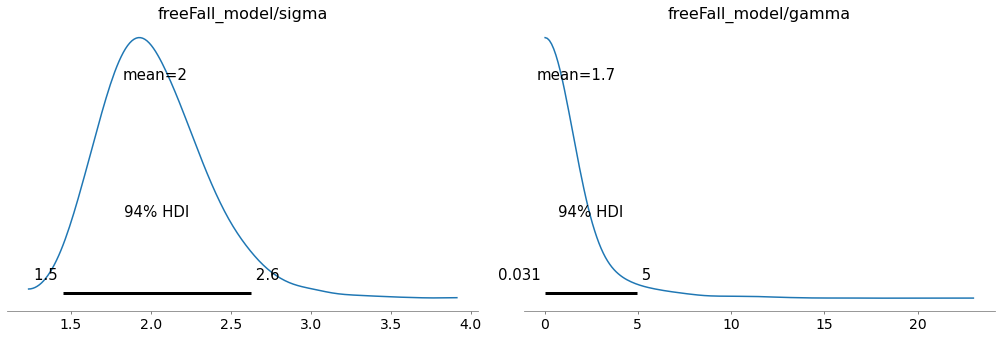

In [61]:
az.plot_posterior(trace, var_names=['freeFall_model/sigma','freeFall_model/gamma']);

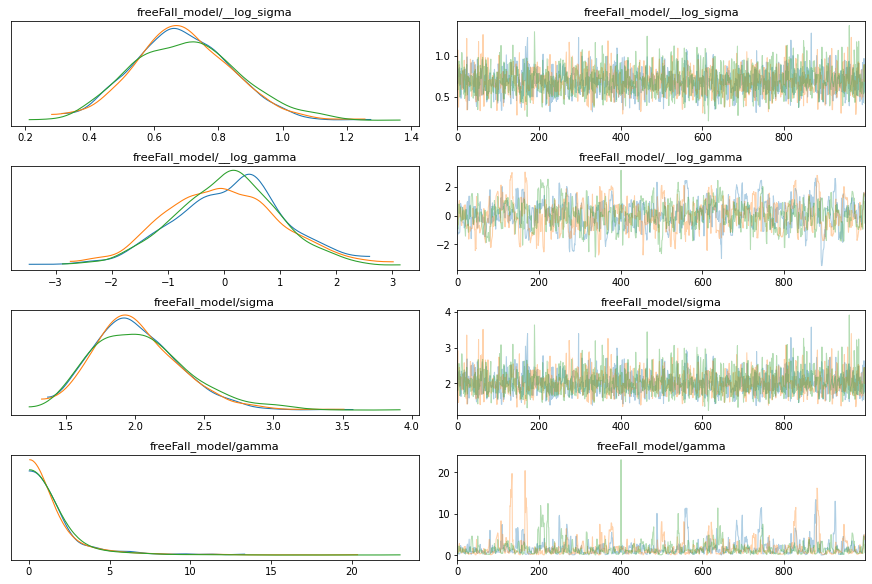

In [62]:
az.plot_trace(trace);

In [63]:
draws_posterior = pm.sample_posterior_predictive(freeFall_model(yobs), trace, inplace=False)
draws_posterior.posterior_predictive

<xarray.Dataset>
Dimensions:                 (chain: 3, draw: 1000, freeFall_model/Y_dim_0: 20, freeFall_model/Y_dim_1: 1)
Coordinates:
  * chain                   (chain) int64 0 1 2
  * draw                    (draw) int64 0 1 2 3 4 5 ... 994 995 996 997 998 999
  * freeFall_model/Y_dim_0  (freeFall_model/Y_dim_0) int64 0 1 2 3 ... 17 18 19
  * freeFall_model/Y_dim_1  (freeFall_model/Y_dim_1) int64 0
Data variables:
    freeFall_model/Y        (chain, draw, freeFall_model/Y_dim_0, freeFall_model/Y_dim_1) float32 1.0075655 ... 49.304813
Attributes:
    created_at:     2020-07-24T16:13:25.510165
    arviz_version:  0.9.0

In [64]:
predictive_samples = draws_posterior.posterior_predictive.data_vars['freeFall_model/Y'].values

In [65]:
np.shape(predictive_samples)

(3, 1000, 20, 1)

In [25]:
median_ppc= np.median(predictive_samples,axis=(0, 1))
promedio  = np.mean(predictive_samples, axis=(0, 1))
CriL_ppc  = np.percentile(predictive_samples,q=2.5,axis=(0, 1))
CriU_ppc  = np.percentile(predictive_samples,q=97.5,axis=(0, 1))

In [26]:
print(np.shape(median_ppc))
print(np.shape(promedio))
print(np.shape(CriL_ppc))
print(np.shape(CriU_ppc))

(20, 1)
(20, 1)
(20, 1)
(20, 1)


In [27]:
print(type(median_ppc))
print(type(promedio))
print(type(CriL_ppc))
print(type(CriU_ppc))

<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


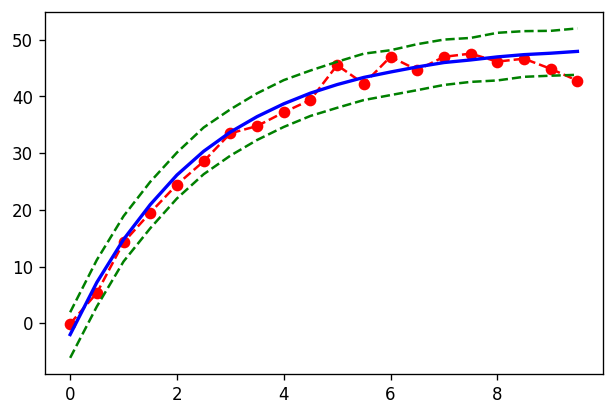

In [28]:
fig, ax = plt.subplots(dpi=120)
ax.plot(times,yobs, linestyle='dashed', marker='o', color='red')
ax.plot(times,median_ppc, color='b', lw=2)
#ax.fill_between(times,CriL_ppc,CriU_ppc, color='b', alpha=0.1)
plt.plot(times,CriL_ppc, '--', color='g', lw=1.5)
plt.plot(times,CriU_ppc, '--',  color='g', lw=1.5)
# ax.fill_between(ttime,CriL_ppc[:,1],CriU_ppc[:,1],  color='c', alpha=0.1)
# ax.fill_between(ttime,CriL_ppc[:,2],CriU_ppc[:,2],  color='m', alpha=0.1)

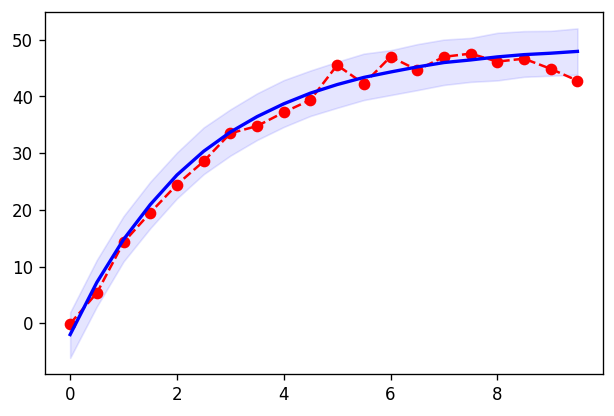

In [29]:
CriL_ppc_mod = CriL_ppc.reshape((20,))
CriU_ppc_mod = CriU_ppc.reshape((20,))
fig, ax = plt.subplots(dpi=120)
ax.plot(times,yobs, linestyle='dashed', marker='o', color='red')
ax.plot(times,median_ppc, color='b', lw=2)
ax.fill_between(times,CriL_ppc_mod,CriU_ppc_mod, color='b', alpha=0.1)
# plt.plot(times,CriL_ppc, '--', color='g', lw=1.5)
# plt.plot(times,CriU_ppc, '--',  color='g', lw=1.5)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: RuntimeWarning: invalid value encountered in log
  if sys.path[0] == '':


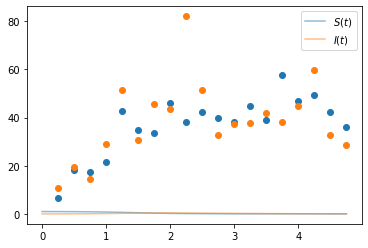

In [30]:
def SIR(x, t, p):
    ds = -p[0]*x[0]*x[1]
    di = p[0]*x[0]*x[1] - p[1]*x[1]
    return ds, di

times = np.arange(0,5,0.25)

beta,lam = 4,1.0
# Create true curves
y_sol = odeint(SIR, t=times, y0=[0.99, 0.01], args=tuple([[4,1.0]]), rtol=1e-8)
# Observational model.  Lognormal likelihood isn't appropriate, but we'll do it anyway
yobs = np.random.lognormal(mean=np.log(y[0::]), sigma=[0.2, 0.3])


plt.plot(times,yobs, marker='o', linestyle='none')
plt.plot(times, y_sol[:,0], color='C0', alpha=0.5, label=f'$S(t)$')
plt.plot(times, y_sol[:,1], color ='C1', alpha=0.5, label=f'$I(t)$')
plt.legend()
plt.show()

In [31]:
def wrapper_ode(model):

   preds= odeint(model, t=times, y0=[0.99, 0.01], args=tuple([[beta, lam]]))
   x_sol = preds
#   x_sol = preds
#   x_S, x_I = preds

#   return np.array([x_S,x_I])
   return np.array([x_sol])

In [32]:
def SIR(t, x, p):
    ds = -p[0]*x[0]*x[1]
    di = p[0]*x[0]*x[1] - p[1]*x[1]
    return ds, di

In [33]:
def soln_ode(modelo):
    # x0 = np.array([N-(p[6] + p[7] + p[8] + p[9] + R0 + P0),p[6],p[7]
    #                ,p[8],p[9],R0,P0]) # SsEIQRP
    x0 = y0=[0.99, 0.01]
    p  = np.array([beta, lam])
           
    soln = solve_ivp(lambda t,x: modelo(t, x, p),
                                [0,len(times)],x0,method='LSODA', 
                                vectorized=True,t_eval=times)
    # result_s=soln.y[1][:]
    # result_Q=soln.y[4][:]
    # result_P=soln.y[6][:]
    
    # return result_s,result_Q,result_P
    result = np.array(soln.y).T

    return result

In [34]:
@pm.model
def SIR_model(y):
#    μ = pm.Deterministic('μ', α + β * x)
#    sigma = yield pm.HalfCauchy('sigma',1)
#    gamma  = yield pm.LogNormal('gamma',0,1)
#    sigma = yield pm.HalfCauchy('sigma',1)
    sigma = yield pm.HalfCauchy('sigma', 1, shape=2)

    # R0 is bounded below by 1 because we see an epidemic has occured
    R0   = yield pm.Normal('R0', 2,1.2)
    lam  = yield pm.LogNormal('lam',2,2)
#    lam  = yield pm.LogNormal('lam',tf.math.log(2),2)
    beta = yield  pm.Deterministic('beta', lam*R0)
#    fit=wrapper_ode(SIR)
    fit=soln_ode(SIR)
    fit_log=np.log(fit)
    fitting=tf.convert_to_tensor(fit_log, dtype=tf.float32)
    # print(tf.shape(sigma))
    # print(tf.shape(gamma))
    # print(tf.shape(fitting))

    Y = yield pm.LogNormal('Y', loc=fitting, scale=sigma, observed=y)
#    Y = yield pm.Normal('Y', loc=fitting, scale=sigma, observed=y)

In [35]:
trace = pm.sample(SIR_model(yobs),num_samples=1000, num_chains=3)
trace

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [36]:
az.plot_posterior(trace, var_names=['SIR_model/beta','SIR_model/lam']);

/usr/local/lib/python3.6/dist-packages/google/colab/_event_manager.py:28: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  func(*args, **kwargs)
/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: constrained_layout not applied.  At least one axes collapsed to zero width or height.
  fig.canvas.print_figure(bytes_io, **kw)


ValueError: ignored

<Figure size 993.6x331.2 with 2 Axes>

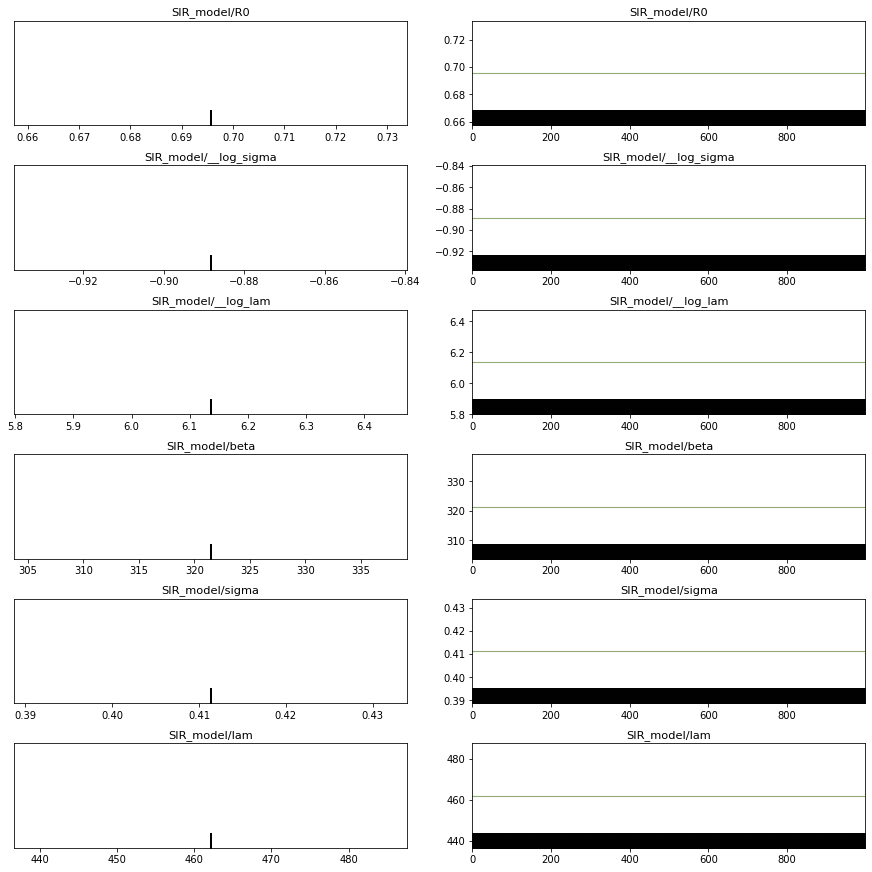

In [37]:
az.plot_trace(trace);

In [38]:
draws_posterior = pm.sample_posterior_predictive(SIR_model(yobs), trace, inplace=True)
draws_posterior.posterior_predictive

<xarray.Dataset>
Dimensions:            (SIR_model/Y_dim_0: 20, SIR_model/Y_dim_1: 2, chain: 3, draw: 1000)
Coordinates:
  * chain              (chain) int64 0 1 2
  * draw               (draw) int64 0 1 2 3 4 5 6 ... 994 995 996 997 998 999
  * SIR_model/Y_dim_0  (SIR_model/Y_dim_0) int64 0 1 2 3 4 5 ... 15 16 17 18 19
  * SIR_model/Y_dim_1  (SIR_model/Y_dim_1) int64 0 1
Data variables:
    SIR_model/Y        (chain, draw, SIR_model/Y_dim_0, SIR_model/Y_dim_1) float32 0.929538 ... 0.05134179
Attributes:
    created_at:     2020-07-24T16:10:52.092231
    arviz_version:  0.9.0

In [39]:
predictive_samples = draws_posterior.posterior_predictive.data_vars['SIR_model/Y'].values

In [40]:
median_ppc= np.median(predictive_samples,axis=(0, 1))
promedio  = np.mean(predictive_samples, axis=(0, 1))
CriL_ppc  = np.percentile(predictive_samples,q=2.5,axis=(0, 1))
CriU_ppc  = np.percentile(predictive_samples,q=97.5,axis=(0, 1))

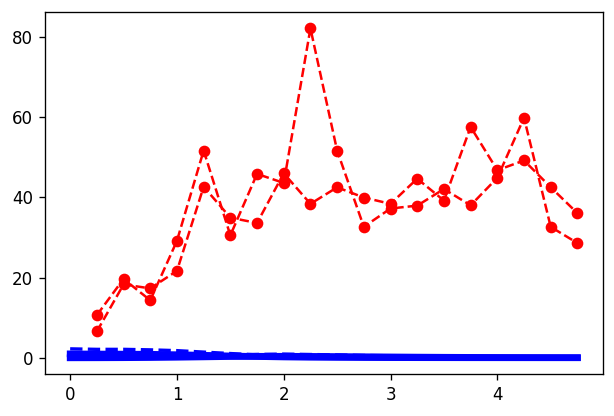

In [41]:
fig, ax = plt.subplots(dpi=120)
plt.plot(times,yobs, label='observed speed', linestyle='dashed', marker='o', color='red')
plt.plot(times,median_ppc, color='b', lw=4)
plt.plot(times,CriL_ppc, '--', color='b', lw=2)
plt.plot(times,CriU_ppc, '--',  color='b', lw=2)

In [42]:
y_obs=yobs.astype('float32')
#tf.convert_to_tensor([1, 1], dtype=tf.float64)

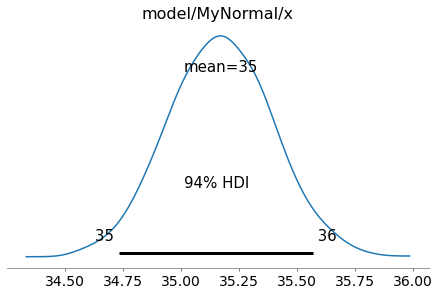

In [43]:
@pm.model
def MyNormal(name, loc=0, scale=10):
    x = yield pm.Normal(name, loc=loc, scale=scale)
    return x

@pm.model
def model(y):
    x = yield MyNormal('x')
    y = yield pm.Normal('y', loc=x, scale=1, observed=y)
    
trace = pm.sample(model(y), num_chains=3)
az.plot_posterior(trace, var_names=['model/MyNormal/x']);    

In [44]:
import pandas as pd
import corner
import seaborn as sns; sns.set(style="ticks", color_codes=True)

TotalNumIter =  2000
NumProc      =    2
NumEqs       =    7
NumParams    =    6

# pesos para la cuadratura trapezoidal
weigths = np.ones(11)
weigths[0] = 0.5
weigths[-1] = 0.5


data=pd.read_csv("covidMexico.csv")
yobs=data[["Suspects","New cases (HUC)","Deaths (HUC)"]]
y_obs_temp=yobs.to_numpy()

y_obs=y_obs_temp.astype(float)   
muM       = 0.0171361/365
nu        = 0.0058/365
k_conts   = 500/365 # number of contacts per year
tau_Q     =1/14  #(1/tau_Q := period of quarantined) 
rho       =1/15    
N         = 128932753
#   tau_A = 1/14 # period of being active: 14 days

# Initial conditions

R0 = 0
P0 = 0

#Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0=0.5,.2,.2,.2,.2,.2,.2,.2,.2,.2
#save_results_to = 'MODEL_PRED/'
  
# # HUC
Suspect = data["Suspects"]
Sick = data["New cases (HUC)"]
Deaths  = data["Deaths (HUC)"] 

# datahub
# Sick = data["New cases (datahub)"]
# Deaths  = data["Deaths (datahub)"] 

## OWD
#Sick = data["New cases (OWD)"]
#Deaths  = data["Deaths (OWD)"] + data["Recovered (noData)"]

# # DGE
# Sick = data["New cases (DGE)"]
# Deaths  = data["Deaths (DGE)"] 

#ttime = np.linspace(0.0,float(len(Sick)),len(Sick))
#ttime = list(float(i) for i in range(len(Sick)))
ttime = np.array([float(i)  for i in range( len(Sick) )])
t_pred = np.array([float(i) for i in range( 120 )])

nn = len(ttime)
dt = 1.0/(10.0*nn)
n_quad =int(10.0*nn+1)
t_quad = np.linspace(ttime[0],ttime[-1],n_quad)


epsil=1e-3

fig0= plt.figure()
plt.plot(ttime, Suspect,'m.', ttime, Sick,'r.',ttime, Deaths,'g.')
#plt.show()
plt.savefig( 'Suspects_NewCases_Deaths.eps')

ModuleNotFoundError: ignored

In [ ]:
type(times)
np.shape(times)
np.shape(ttime)

In [ ]:
TotalNumIter = 4000
NumProc      = 2
NumEqs       = 7
NumParams    = 10

# pesos para la cuadratura trapezoidal
weigths = np.ones(11)
weigths[0] = 0.5
weigths[-1] = 0.5


#data=pd.read_csv("covidMexico.csv")
data=pd.read_csv("/content/mnt/My Drive/Colab Notebooks/covidMexico.csv")
yobs=data[["Suspects","New cases (HUC)","Deaths (HUC)"]]
y_obs_temp=yobs.to_numpy()

y_obs=y_obs_temp.astype(float)
   
muM    = 0.0171361/365
nu    = 0.0058/365
#   tau_A = 1/14 # period of being active: 14 days
k_conts     = 500/365 # number of contacts per year
tau_Q =1/14  #(1/tau_Q := period of quarantined) 
rho  =1/15    
N     = 128932753

# Initial conditions

R0 = 0
P0 = 0


#save_results_to = 'MODEL_PRED/'
  
# # HUC
Suspect = data["Suspects"]
Sick = data["New cases (HUC)"]
Deaths  = data["Deaths (HUC)"] 

# datahub
# Sick = data["New cases (datahub)"]
# Deaths  = data["Deaths (datahub)"] 

## OWD
#Sick = data["New cases (OWD)"]
#Deaths  = data["Deaths (OWD)"] + data["Recovered (noData)"]

# # DGE
# Sick = data["New cases (DGE)"]
# Deaths  = data["Deaths (DGE)"] 

#ttime = np.linspace(0.0,float(len(Sick)),len(Sick))
#ttime = list(float(i) for i in range(len(Sick)))
ttime = np.array([float(i)  for i in range( len(Sick) )])
t_pred = np.array([float(i) for i in range( 120 )])

epsil=1e-2

fig0= plt.figure()
plt.plot(ttime, Suspect,'m.', ttime, Sick,'r.',ttime, Deaths,'g.')
#plt.show()
plt.savefig( 'Suspects_NewCases_Deaths.eps')

In [ ]:
def contact_tracing(x,t,p):
    
  """
  model:SsEIQRP
  
  Parameters:
  p[0]: beta factor b
  p[1]: qu contact tracing rate
  p[2]: delta Detection and isolation rate
  p[3]: alpha transmision rate from E to I
  p[4]: gamma recovery rate
  p[5]: sigma death rate by disease 
  
  State variables: SsEIQRP
  
  x[0]: Susceptibles
  x[1]: suspects
  x[2]: Exposeds
  x[3]: Infecteds
  x[4]: Quarainteds
  x[5]: Recovereds
  x[6]: Deaths
  """
  
  dS = muM*N -(k_conts*p[0]*x[3] + p[1]*k_conts*(1- p[0])*x[3]   )*x[0]/N \
         + tau_Q*x[1] - nu*x[0]
  ds =  p[1]*k_conts*(1- p[0])*x[3] *x[0]/N - (tau_Q + nu)*x[1]
  dE =  k_conts*p[0]*(1- p[1])*x[3] *x[0]/N - (p[3] + nu)*x[2] 
  dI =  p[3]*x[2] - ( p[5] + p[2] + nu  )* x[3]
  dQ =  p[1]* k_conts* p[0]*x[3] *x[0]/N + p[2]*x[3] - (tau_Q + p[5]  )*x[4]
  dR = p[4]*x[3] + tau_Q*x[4]
  dP = p[5]*x[4]
  

  return dS,ds,dE,dI,dQ,dR,dP  

In [ ]:
def soln_ode(modelo):
#    p  = np.array([Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0])
    x0 = np.array([N-(s0 + E0 + I0 + Q0 + R0 + P0),s0,E0
                   ,I0,Q0,R0,P0]) # SsEIQRP

    soln = odeint(modelo,x0,ttime,tuple([[Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0]]) )    
    result_s=soln[:,1]
    result_Q=soln[:,4]
    result_P=soln[:,6]
    # X_s=np.where(result_s <= 0, epsil, result_s)
    # X_Q=np.where(result_Q <= 0, epsil, result_Q)
    # X_P=np.where(result_P <= 0, epsil, result_P)

    return np.array([result_s,result_Q,result_P]).T
#    return np.array([X_s,X_Q,X_P]).T

In [ ]:
def contact_tracing(t,x,p):
    
  """
  model:SsEIQRP
  
  Parameters:
  p[0]: beta factor b
  p[1]: qu contact tracing rate
  p[2]: delta Detection and isolation rate
  p[3]: alpha transmision rate from E to I
  p[4]: gamma recovery rate
  p[5]: sigma death rate by disease 
  
  State variables: SsEIQRP
  
  x[0]: Susceptibles
  x[1]: suspects
  x[2]: Exposeds
  x[3]: Infecteds
  x[4]: Quarainteds
  x[5]: Recovereds
  x[6]: Deaths
  """
  
  dS = muM*N -(k_conts*p[0]*x[3] + p[1]*k_conts*(1- p[0])*x[3]   )*x[0]/N \
         + tau_Q*x[1] - nu*x[0]
  ds =  p[1]*k_conts*(1- p[0])*x[3] *x[0]/N - (tau_Q + nu)*x[1]
  dE =  k_conts*p[0]*(1- p[1])*x[3] *x[0]/N - (p[3] + nu)*x[2] 
  dI =  p[3]*x[2] - ( p[5] + p[2] + nu  )* x[3]
  dQ =  p[1]* k_conts* p[0]*x[3] *x[0]/N + p[2]*x[3] - (tau_Q + p[5]  )*x[4]
  dR = p[4]*x[3] + tau_Q*x[4]
  dP = p[5]*x[4]
  

  return dS,ds,dE,dI,dQ,dR,dP  

In [ ]:
def soln_ode(modelo):
    p  = np.array([Beta,qu,delta,alfa,gama,sigm,s0,E0,I0,Q0])
    x0 = np.array([N-(p[6] + p[7] + p[8] + p[9] + R0 + P0),p[6],p[7]
                   ,p[8],p[9],R0,P0]) # SsEIQRP
#    x0 = np.array([-2.])
    

#    result =  np.zeros(len(times))
    # result_s = np.zeros(len(ttime))   
    # result_Q = np.zeros(len(ttime))
    # result_P = np.zeros(len(ttime))
#    soln = integrate.odeint(modelo,x0,ttime,args=(p,))            
    soln = solve_ivp(lambda t,x: modelo(t, x, p),
                                [0,len(ttime)],x0,method='LSODA', 
                                vectorized=True,t_eval=ttime)
    result_s=soln.y[1][:]
    result_Q=soln.y[4][:]
    result_P=soln.y[6][:]
    # X_s=np.where(result_s <= 0, epsil, result_s)
    # X_Q=np.where(result_Q <= 0, epsil, result_Q)
    # X_P=np.where(result_P <= 0, epsil, result_P)

    return np.array([result_s,result_Q,result_P]).T
#    return np.array([X_s,X_Q,X_P]).T

In [ ]:
@pm.model
def CT_model(y):

    Beta   = yield pm.LogNormal('Beta', 0, 1.5)
#    Beta   = yield pm.Uniform('Beta',  low=0, high=1.2)
    qu     = yield pm.Uniform('qu'  ,  low=0, high=0.5)
    delta  = yield pm.Uniform('delta'  ,low=0, high=2.0)
    alfa   = yield pm.Uniform('alfa'  , low=0, high=2.0)
    gama   = yield pm.Uniform('gama'  , low=0, high=2.0)
    sigm   = yield pm.Uniform('sigm'  , low=0, high=2.0)
    s0     = yield pm.Uniform('s0'  , low=0, high=1e2)
    E0     = yield pm.Uniform('E0'  , low=0, high=3e3)
    I0     = yield pm.Uniform('I0'  , low=0, high=1e3)
    Q0     = yield pm.Uniform('Q0'  , low=0, high=2e2)

    #μ = pm.Deterministic('μ', α + β * x)
    sigma = yield pm.HalfCauchy('sigma',1)
    # gamma  = yield pm.LogNormal('gamma',0,1)

    fit=soln_ode(contact_tracing)
#    fit_log=np.log(fit)
    fitting=tf.convert_to_tensor(fit, dtype=tf.float32)
    # print(tf.shape(sigma))
    # print(tf.shape(gamma))
    # print(tf.shape(fitting))
#    Y = yield pm.Poisson('Y', rate=fitting,  observed=y)
    Y = yield pm.Normal('Y', loc=fitting, scale=sigma, observed=y)
#    Y = yield pm.LogNormal('Y', loc=fitting, scale=sigma, observed=y)

In [ ]:
trace = pm.sample(CT_model(y_obs),num_samples=1000, num_chains=2)
trace

In [ ]:
draws_posterior = pm.sample_posterior_predictive(CT_model(y_obs), trace, inplace=True)
draws_posterior.posterior_predictive

In [ ]:
predictive_samples = draws_posterior.posterior_predictive.data_vars['CT_model/Y'].values

In [ ]:
median_ppc= np.median(predictive_samples,axis=(0, 1))
promedio  = np.mean(predictive_samples, axis=(0, 1))
CriL_ppc  = np.percentile(predictive_samples,q=2.5,axis=(0, 1))
CriU_ppc  = np.percentile(predictive_samples,q=97.5,axis=(0, 1))

In [ ]:
print(np.shape(median_ppc))
print(np.shape(promedio))
print(np.shape(CriL_ppc))
print(np.shape(CriU_ppc))

In [ ]:
# CriL_ppc = CriL_ppc_mod.reshape((len(ttime),))
# CriU_ppc = CriU_ppc_mod.reshape((len(ttime),))

fig, ax = plt.subplots(dpi=120)
ax.plot(ttime,yobs, linestyle='dashed', marker='o', color='red')
ax.plot(ttime,median_ppc, color='b', lw=2)
ax.fill_between(ttime,CriL_ppc[:,0],CriU_ppc[:,0], color='b', alpha=0.1)
ax.fill_between(ttime,CriL_ppc[:,1],CriU_ppc[:,1],  color='c', alpha=0.1)
ax.fill_between(ttime,CriL_ppc[:,2],CriU_ppc[:,2],  color='m', alpha=0.1)

In [ ]:
median_ppc

In [ ]:
fig, ax = plt.subplots(dpi=120)
ax.plot(ttime,y_obs[:,0], linestyle='dashed', marker='o', color='red')
ax.plot(ttime,y_obs[:,2], linestyle='dashed', marker='o', color='red')
ax.plot(ttime,median_ppc[:,0], color='b', lw=2)
ax.plot(ttime,median_ppc[:,2], color='b', lw=2)
ax.fill_between(ttime,CriL_ppc[:,0],CriU_ppc[:,0], color='b', alpha=0.1)
ax.fill_between(ttime,CriL_ppc[:,2],CriU_ppc[:,2],  color='m', alpha=0.1)

In [ ]:
az.plot_trace(trace);

In [ ]:
print(y_obs.dtype)

In [ ]:
np.shape(y_obs)

## Linear basis function models

I introduced regression with linear basis function models in a [previous article](https://nbviewer.jupyter.org/github/krasserm/bayesian-machine-learning/blob/master/bayesian_linear_regression.ipynb). To recap, a linear regression model is a linear function of the parameters but not necessarily of the input. Input $x$ can be expanded with a set of non-linear basis functions $\phi_j(x)$, where $(\phi_1(x), \dots, \phi_M(x))^T = \boldsymbol\phi(x)$, for modeling a non-linear relationship between input $x$ and a function value $y$.

$$
y(x, \mathbf{w}) = w_0 + \sum_{j=1}^{M}{w_j \phi_j(x)} = w_0 + \mathbf{w}_{1:}^T \boldsymbol\phi(x) \tag{1}
$$

For simplicity I'm using a scalar input $x$ here. Target variable $t$ is given by the deterministic function $y(x, \mathbf{w})$ and Gaussian noise $\epsilon$.

$$
t = y(x, \mathbf{w}) + \epsilon \tag{2}
$$

Here, we can choose between polynomial and Gaussian basis functions for expanding input $x$. 

In [ ]:
from functools import partial
from scipy.stats import norm

def polynomial_basis(x, power):
    return x ** power

def gaussian_basis(x, mu, sigma):
    return norm(loc=mu, scale=sigma).pdf(x).astype(np.float32)

def _expand(x, bf, bf_args):
    return np.stack([bf(x, bf_arg) for bf_arg in bf_args], axis=1)

def expand_polynomial(x, degree=3):
    return _expand(x, bf=polynomial_basis, bf_args=range(1, degree + 1))

def expand_gaussian(x, mus=np.linspace(0, 1, 9), sigma=0.3):
    return _expand(x, bf=partial(gaussian_basis, sigma=sigma), bf_args=mus)

# Choose between polynomial and Gaussian expansion
# (by switching the comment on the following two lines)
expand = expand_polynomial
#expand = expand_gaussian

For example, to expand two input values `[0.5, 1.5]` into a polynomial design matrix of degree `3` we can use

In [ ]:
expand_polynomial(np.array([0.5, 1.5]), degree=3)

The power of `0` is omitted here and covered by a $w_0$ in the model.

## Example dataset

The example dataset consists of `N` noisy samples from a sinusoidal function `f`.

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline

from bayesian_linear_regression_util import (
    plot_data, 
    plot_truth
)

def f(x, noise=0):
    """Sinusoidal function with optional Gaussian noise."""
    return 0.5 + np.sin(2 * np.pi * x) + np.random.normal(scale=noise, size=x.shape)

# Number of samples
N = 10

# Constant noise 
noise = 0.3

# Noisy samples 
x = np.linspace(0, 1, N, dtype=np.float32)
t = f(x, noise=noise)

# Noise-free ground truth 
x_test = np.linspace(0, 1, 100).astype(np.float32)
y_true = f(x_test)

plot_data(x, t)
plot_truth(x_test, y_true)

## Implementation with PyMC4

### Model definition

The model definition directly follows from Eq. $(1)$ and Eq. $(2)$ with normal priors over parameters. The size of parameter vector `w_r` ($\mathbf{w}_{1:}$ in Eq. $(1)$) is determined by the number of basis functions and set via the `batch_stack` parameter. With the above default settings, it is 3 for polynomial expansion and 9 for Gaussian expansion.

In [ ]:
import tensorflow as tf

@pm.model
def model(Phi, t, sigma=noise):
    """Linear model generator.
    
    Args:
    - Phi: design matrix (N,M)
    - t: noisy target values (N,)
    - sigma: known noise of t
    """

    w_0 = yield pm.Normal(name='w_0', loc=0, scale=10)
    w_r = yield pm.Normal(name='w_r', loc=0, scale=10, batch_stack=Phi.shape[1])
    
    mu = w_0 + tf.tensordot(w_r, Phi.T, axes=1)
    
    yield pm.Normal(name='t_obs', loc=mu, scale=sigma, observed=t)

### Inference

Tensorflow will automatically run inference on a GPU if available. With the current version of PyMC4, inference on a GPU is quite slow compared to a multi-core CPU (need to investigate that in more detail). To enforce inference on a CPU set environment variable `CUDA_VISIBLE_DEVICES` to an empty value. There is no progress bar visible yet during sampling but the following shouldn't take longer than a 1 minute.

In [ ]:
trace = pm.sample(model(expand(x), t), num_chains=3, burn_in=100, num_samples=1000)

In [ ]:
az.plot_trace(trace);

In [ ]:
az.plot_posterior(trace, var_names="model/w_0");
az.plot_posterior(trace, var_names="model/w_r");

### Prediction

To obtain posterior predictive samples for a test set `x_test` we simply call the model generator function again with the expanded test set. This is a nice improvement over PyMC3 which required to setup a shared Theano variable for setting test set values. Target values are ignored during predictive sampling, only the shape of the target array `t` matters.

In [ ]:
draws_posterior = pm.sample_posterior_predictive(model(expand(x_test), t=np.zeros_like(x_test)), trace, inplace=False)
draws_posterior.posterior_predictive

The predictive mean and standard deviation is obtained by averaging over chains (axis `0`) and predictive samples (axis `1`) for each of the 100 data points in `x_test` (axis `2`).

In [ ]:
predictive_samples = draws_posterior.posterior_predictive.data_vars['model/t_obs'].values

m = np.mean(predictive_samples, axis=(0, 1))
s = np.std(predictive_samples, axis=(0, 1))

These statistics can be used to plot model predictions and their uncertainties (together with the ground truth and the noisy training dataset).

In [ ]:
plt.fill_between(x_test, m + s, m - s, alpha = 0.5, label='Predictive std. dev.')
plt.plot(x_test, m, label='Predictive mean');

plot_data(x, t)
plot_truth(x_test, y_true, label=None)

plt.legend();

Try running the example again with Gaussian expansion i.e. setting `expand = expand_gaussian` and see how it compares to polynomial expansion. Also try running with a different number of basis functions by overriding the default arguments of `expand_polynomial` and `expand_gaussian`. You can find more PyMC4 examples in the [notebooks](https://github.com/pymc-devs/pymc4/tree/master/notebooks) diretory of the PyMC4 project.